In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

!ls /content/gdrive/My\ Drive/HW3


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
indoor_data


In [0]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
from PIL import Image  #image.op
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage
from skimage import io, transform,color
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import models
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [0]:
root_dir = '/content/gdrive/My Drive/HW3/indoor_data/indoor_data' # change the value of root_dir variable as your root path
csv_path = '/content/gdrive/My Drive/HW3/indoor_data'


In [0]:
torch.set_default_dtype(torch.float64)

In [0]:
class ImageDataset(Dataset):
    """MIT image dataset."""
    
    def __init__(self, root_dir,csv_file,transform = None):
        self.file = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.file)

    def __getitem__(self, idx):
        img_name = self.root_dir+'/'+self.file.iloc[idx,0]+'/'+self.file.iloc[idx,1]
        image = io.imread(img_name, as_gray=False)
        if self.transform:
            image = self.transform(image)
        sample = {'image': image, 'class': torch.from_numpy(np.array(self.file.iloc[idx,2]))}
        return sample

    class Rescale(object):
        """Rescale the image in a sample to a given size.
        Args:
            output_size (tuple or int): Desired output size. If tuple, output is
                matched to output_size. If int, smaller of image edges is matched
                to output_size keeping aspect ratio the same.
        """
        
        def __init__(self, output_size):
            assert isinstance(output_size, (int, tuple))
            self.output_size = output_size
    
        def __call__(self, sample):
            image = sample
    
            h, w = image.shape[:2]
            if isinstance(self.output_size, int):
                if h > w:
                    new_h, new_w = self.output_size * h / w, self.output_size
                else:
                    new_h, new_w = self.output_size, self.output_size * w / h
            else:
                new_h, new_w = self.output_size
    
            new_h, new_w = int(new_h), int(new_w)
    
            img = transform.resize(image, (new_h, new_w))
    
            # h and w are swapped for landmarks because for images,
            # x and y axes are axis 1 and 0 respectively
            return img
    
    class RandomCrop(object):
        """Crop randomly the image in a sample.
        Args:
            output_size (tuple or int): Desired output size. If int, square crop
                is made.
        """
        def __init__(self, output_size):
            assert isinstance(output_size, (int, tuple))
            if isinstance(output_size, int):
                self.output_size = (output_size, output_size)
            else:
                assert len(output_size) == 2
                self.output_size = output_size
    
        def __call__(self, sample):
            image = sample
    
            h, w = image.shape[:2]
            new_h, new_w = self.output_size
    
            top = np.random.randint(0, h - new_h)
            left = np.random.randint(0, w - new_w)
    
            image = image[top: top + new_h,
                          left: left + new_w]
            return image
    
    class ToTensor(object):
        """Convert ndarrays in sample to Tensors."""
        def __call__(self, sample):
            image = sample
            if (len(sample.shape) == 2):
              image = skimage.color.gray2rgb(image)
#               image = image.reshape(image.shape[0],image.shape[1],3)
            
            # swap color axis because
            # numpy image: H x W x C
            # torch image: C X H X W
            image = image.transpose((2, 0, 1))
#            image = image.transpose((0, 1))
            return (torch.from_numpy(image).float())
            
#    class Normalize(object):
#        """Normalize tensor"""
#        def __call__(self, sample):
#            image = sample
#            # swap color axis because
#            # numpy image: H x W x C
#            # torch image: C X H X W
# #            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
# #            image = normalize(image.float())
# #            image = normalize(image.float())
#            mean=[0.485, 0.456, 0.406]
#            std=[0.229, 0.224, 0.225]
#            image = ((image - np.mean(image,axis=(1,0)))/np.std(image,axis=(1,0)))
#            image = (image*np.array(std)) + np.array(mean)
#            return image
            
    class RandHorzFlip(object):
        def __call__(self, sample):
            image = sample
            image = Image.fromarray(np.uint8(image*255))
            flip = transforms.RandomHorizontalFlip()
            image = flip(image)
            image = np.array(image)
            return image 
            
#    class Grayscale(object):
#        def __call__(self, sample):
#            image = sample['image']
#            image = Image.fromarray(np.uint8(image*255))
#            gray = transforms.Grayscale(num_output_channels=1)
#            image = gray(image)
#            image = np.array(image)
#            return {'image': image,
#                    'class': sample['class']}

In [0]:
transformed_dataset_tr = ImageDataset(root_dir=root_dir,csv_file = csv_path+'/train1.csv',transform=transforms.Compose([ImageDataset.Rescale(100),ImageDataset.RandomCrop(64),ImageDataset.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))
transformed_dataset_test = ImageDataset(root_dir=root_dir,csv_file = csv_path+'/test.csv',transform=transforms.Compose([ImageDataset.Rescale(100),ImageDataset.RandomCrop(64),ImageDataset.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))
transformed_dataset_val = ImageDataset(root_dir=root_dir,csv_file = csv_path+'/val.csv',transform=transforms.Compose([ImageDataset.Rescale(100),ImageDataset.RandomCrop(64),ImageDataset.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

# transformed_dataset_tr = ImageDataset(root_dir=root_dir,csv_file = csv_path+'/train1.csv',transform=transforms.Compose([transforms.ToTensor(),transforms.RandomCrop(256), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))
# transformed_dataset_test = ImageDataset(root_dir=root_dir,csv_file = csv_path+'/test.csv',transform=transforms.Compose([transforms.ToTensor(),transforms.RandomCrop(256), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))
# transformed_dataset_val = ImageDataset(root_dir=root_dir,csv_file = csv_path+'/val.csv',transform=transforms.Compose([transforms.ToTensor(),transforms.RandomCrop(256), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

dataloader_train = DataLoader(transformed_dataset_tr, batch_size=16, shuffle=True)
dataloader_test = DataLoader(transformed_dataset_test, batch_size=16, shuffle=False)
dataloader_val = DataLoader(transformed_dataset_val, batch_size=16, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([16, 3, 64, 64]) torch.Size([16])


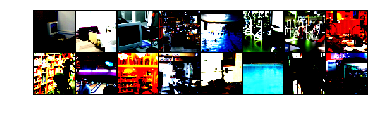

In [0]:
def show_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch,label = sample_batched['image'], sample_batched['class']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i_batch, sample_batched in enumerate(dataloader_train):
    print(i_batch, sample_batched['image'].size(),sample_batched['class'].size())

    # observe 4th batch and stop.
    if i_batch == 0:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [0]:
import torch.nn as nn
import torch.optim as optim

In [0]:
# USE THIS CODE CELL TO DEFINE CNN CLASS
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.fc = nn.Linear(1000, 200)
        self.fc1 = nn.Linear(200, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = self.model(x)
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.fc(x)
        x = self.fc1(x)
        return F.log_softmax(x)

In [0]:
model = Net().float()
device = 'cuda'
if device == 'cuda':
  model = nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 81952199.67it/s]


In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

In [0]:
def train(epoch):
    model.train()
    for batch_idx, data1 in enumerate(dataloader_train):
        data, target = data1['image'], (data1['class'].to(dtype=torch.long).to(device))
#         print(target.type())
        optimizer.zero_grad()
        output = model(data)
#         print(output.shape)
#         print(target.shape)
        loss = F.nll_loss(output, target)
#         loss = loss_tr(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader_train.dataset),
                100. * batch_idx / len(dataloader_train), loss.item()))
            
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data1 in dataloader_test:
        data, target = data1['image'], (data1['class'].to(dtype=torch.long).to(device))
        output = model(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).item()
#         test_loss += loss_tr(output,target)
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(dataloader_test.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dataloader_test.dataset),
        100. * correct / len(dataloader_test.dataset)))

In [0]:
torch.save(model.state_dict(), csv_path+"/pretrained.csv")

In [0]:
for epoch in range(1, 30):
    train(epoch)
    test()

Train Epoch: 1 [0/1441 (0%)]	Loss: 3.168963
Train Epoch: 1 [160/1441 (11%)]	Loss: 3.284898
Train Epoch: 1 [320/1441 (22%)]	Loss: 1.603317
Train Epoch: 1 [480/1441 (33%)]	Loss: 2.365359
Train Epoch: 1 [640/1441 (44%)]	Loss: 2.645603
Train Epoch: 1 [800/1441 (55%)]	Loss: 1.928992
Train Epoch: 1 [960/1441 (66%)]	Loss: 2.113431
Train Epoch: 1 [1120/1441 (77%)]	Loss: 2.185468
Train Epoch: 1 [1280/1441 (88%)]	Loss: 2.012404
Train Epoch: 1 [90/1441 (99%)]	Loss: 2.471391

Test set: Average loss: 1.4495, Accuracy: 237/431 (54%)

Train Epoch: 2 [0/1441 (0%)]	Loss: 1.415320
Train Epoch: 2 [160/1441 (11%)]	Loss: 1.538193
Train Epoch: 2 [320/1441 (22%)]	Loss: 1.271662
Train Epoch: 2 [480/1441 (33%)]	Loss: 0.729871
Train Epoch: 2 [640/1441 (44%)]	Loss: 1.279841
Train Epoch: 2 [800/1441 (55%)]	Loss: 1.033928
Train Epoch: 2 [960/1441 (66%)]	Loss: 1.458490
Train Epoch: 2 [1120/1441 (77%)]	Loss: 1.369419
Train Epoch: 2 [1280/1441 (88%)]	Loss: 1.103426
Train Epoch: 2 [90/1441 (99%)]	Loss: 2.511466

Test 

In [0]:
test()


Test set: Average loss: 1.0787, Accuracy: 295/431 (68%)



In [0]:
# torch.cuda.get_device_name(0)
print(next(model.parameters()).is_cuda)

True
